# CatBoost Model for Housing Price Prediction

## Project Overview
This notebook implements the **CatBoost Model** for predicting housing prices using the Ames Housing dataset.  
The model architecture and training setup follow the original pipeline from the research paper.  
**Paper:** *Prediction of House Price Using Machine Learning 
Algorithms*

After implementing the paper’s pipeline end-to-end, I added my own evaluation metrics and visualizations to better understand the model’s predictions.

---

## Paper Pipeline Implementation

In this section, I strictly follow the steps from the FT-Transformer paper and the official codebase:

## Data Preparation

The dataset is loaded from the provided *train.csv* file.
The IEEE paper used data cleaning, encoding and splitting before training.  
Here, I follow similar steps:

- Load dataset  
- Separate features and target  
- Identify categorical feature indexes (CatBoost handles them internally)  
- Train/validation split (80/20)  

---
## Preprocessing

CatBoost natively handles:

- Missing values  
- Categorical features  
- Internal encoding (no manual label encoding needed)

So the pipeline is simpler compared to other ML models.

We only need to:

- Identify categorical columns  
- Split the data  
---
# CatBoost Regression — Pipeline

The paper used CatBoost with:

- Built-in handling of categorical data  
- Minimal preprocessing  
- RMSE-based evaluation  

CatBoost was chosen for:

- Best performance  
- Ability to handle many heterogeneous features  
- Fast training  
- Strong generalization  

---

## Model Evaluation — Regression Metrics

The paper evaluates models using standard regression metrics:

- **MSE (Mean Squared Error)**

To gain deeper insight, I additionally computed:
- **RMSE (Root Mean Squared Error)**
- **R² Score**
- **MAE (Mean Absolute Error)**

These metrics measure how well the model predicts continuous house prices.

In [108]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder

from catboost import CatBoostRegressor, Pool

import matplotlib.pyplot as plt
import seaborn as sns

In [109]:
df = pd.read_csv("data/train.csv")
df.shape

(1460, 81)

In [110]:
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [111]:
df = df.fillna(df.median(numeric_only=True))
df = df.fillna(df.mode().iloc[0])
df.shape

(1460, 81)

In [112]:
categorical_cols = df.select_dtypes(include=["object"]).columns

for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))

In [113]:
target = "SalePrice"

X = df.drop(columns=[target])
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [114]:
categorical_idx = [X_train.columns.get_loc(c) for c in categorical_cols]

train_pool = Pool(X_train, y_train, cat_features=categorical_idx)
test_pool  = Pool(X_test,  y_test,  cat_features=categorical_idx)

In [115]:
model = CatBoostRegressor(
    iterations=800,
    learning_rate=0.05,
    depth=6,
    loss_function="RMSE",
    verbose=False
)

model.fit(train_pool, eval_set=test_pool)

In [116]:
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred)

print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R²:", r2)

MAE: 15881.405189214587
MSE: 691019267.3422716
RMSE: 26287.245335756874
R²: 0.909910054842937


# My Additional Evaluation and Analysis

To extend the analysis and better understand model behavior,  
I include the following **additional evaluations**:

### **1. Price Category Classification**
I converted SalePrice into 3 bins:
- **Low**
- **Mid**
- **High**

Then calculated:
- **Accuracy**
- **Precision**
- **Recall**
- **F1-Score**

This helps interpret pricing patterns more intuitively.

### **2. Visual Analysis**
I generated additional diagnostic plots:
- **Actual vs Predicted** scatter plot  
- **Residuals vs Predictions**  
- **Residual distribution histogram**  

These visualizations help check:
- bias  
- variance  
- under/over-prediction behavior  

In [117]:
y_test_bins = pd.qcut(y_test, q=3, labels=["Low","Mid","High"])
y_pred_bins = pd.qcut(y_pred, q=3, labels=["Low","Mid","High"])

In [118]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

accuracy = accuracy_score(y_test_bins, y_pred_bins)
precision = precision_score(y_test_bins, y_pred_bins, average="weighted")
recall = recall_score(y_test_bins, y_pred_bins, average="weighted")
f1 = f1_score(y_test_bins, y_pred_bins, average="weighted")

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)
print(classification_report(y_test_bins, y_pred_bins))

Accuracy: 0.8253424657534246
Precision: 0.825977969213388
Recall: 0.8253424657534246
F1-score: 0.8256456664682941
              precision    recall  f1-score   support

        High       0.92      0.91      0.91        98
         Low       0.83      0.83      0.83        98
         Mid       0.73      0.74      0.74        96

    accuracy                           0.83       292
   macro avg       0.83      0.82      0.83       292
weighted avg       0.83      0.83      0.83       292



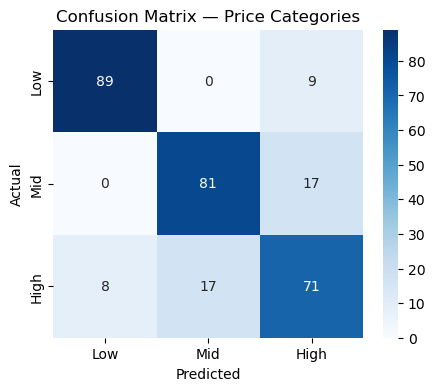

In [119]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test_bins, y_pred_bins)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, cmap="Blues",
            xticklabels=["Low","Mid","High"],
            yticklabels=["Low","Mid","High"])
plt.title("Confusion Matrix — Price Categories")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


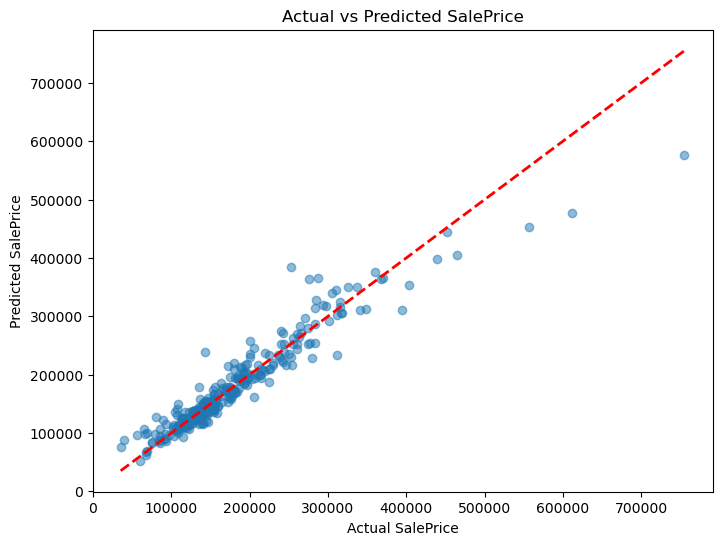

In [120]:
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("Actual SalePrice")
plt.ylabel("Predicted SalePrice")
plt.title("Actual vs Predicted SalePrice")
plt.show()

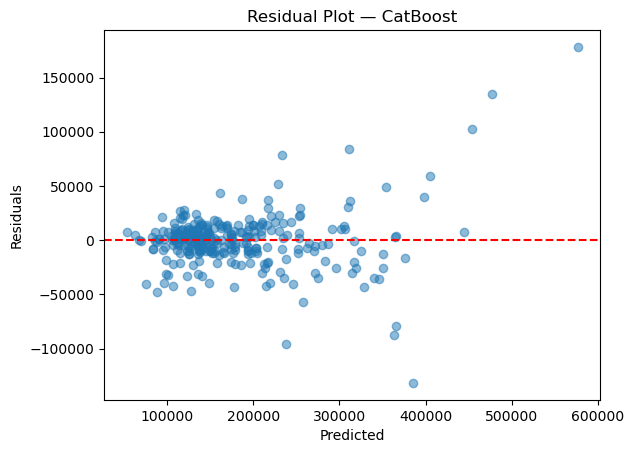

In [121]:
residuals = y_test - y_pred

plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.title("Residual Plot — CatBoost")
plt.show()

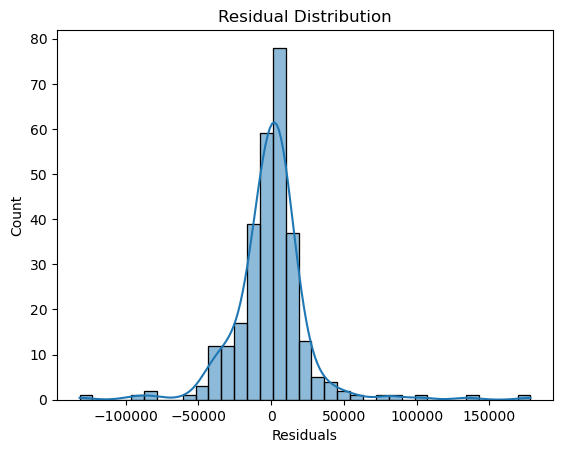

In [122]:
sns.histplot(residuals, kde=True)
plt.xlabel("Residuals")
plt.title("Residual Distribution")
plt.show()